
# <span style="color:rgb(213,80,0)">Simulation study to compare RAVAS with AVAS</span>

This file creates Figures 7.25 and 7.26.

## Create one panel one row of Figure 7.25 and one panel of Figure 7.26

Choose number of simulations (nsimul), sample size (n) and numnber of explanatory variables.


In [1]:
nsimul=100;
n=200;
p1=4;

% nsimul=1000;
%  n=2000;
% p1=9;

msg=0;
LSHIFT=0:0.5:4;

nout=round(n*0.10);

% outindexes = indexes of the units declared as outliers
outindexes=1:nout;
outboo=false(n,1);
outboo(outindexes)=true;

OutliersAVAS=zeros(length(LSHIFT),2);
OutliersAVASnew=zeros(length(LSHIFT),2);
sqbiasAVAS=zeros(length(LSHIFT),2);
mseAVAS=zeros(length(LSHIFT),2);
Niter=zeros(length(LSHIFT),2);

simulnocorr=false;
alsoBadLeveragePoint=false;

rob=true;
tyinitial=true;
PredictorOrderR2=true;
Trapezoid=true;
scail=true;

ij=0;
for lshift=LSHIFT
    disp(['Lshift=' num2str(lshift)])
    ij=ij+1;
    % rng(100)
    outliersAVAS=zeros(nsimul,2);
    outliersAVASnew=outliersAVAS;
    biasAVAS=zeros(nsimul,p1);
    biasAVASnew=zeros(nsimul,p1);
    % Store number of iterations.
    niter=zeros(nsimul,2);

    for jj=1:nsimul

        if simulnocorr==true
            % Simulated data no correlation between X and y
            y=randn(n,1);
            X=randn(n,p1);
            % X(outindexes+100,1:2)=X(outindexes+100,1:2)+lshift;
        else
            % %% Simulated data with correlation between X and y

            [outSIM]=simulateLM(n,'R2',0.80,'nexpl',p1);
            X=outSIM.X;
            y=outSIM.y;
        end
        stdy=std(y);

        y=zscore(y);
        % Contamination
        y(outindexes)=y(outindexes)+lshift;

        % Add bad leverage points
        if alsoBadLeveragePoint ==true
            X(outindexes,:)=X(outindexes,:)+lshift;
        end

        y=exp(y);

        % group=ones(n,1);
        % group(1:nout)=2;
        % yXplot(y,X,'group',group)

        % Traditional AVAS
        out=avas(y,X,'l',4*ones(size(X,2),1));
        % fitlm(out.tX,out.ty,'Exclude',out.outliers)
        outLM=fitlm(out.tX,out.ty,'Exclude',out.outliers);
        bias=outLM.Coefficients{2:end,1}*stdy-1;
        biasAVAS(jj,:)=bias';
        niter(jj,1)=out.niter;

        % Robust AVAS using all options
        out=avas(y,X,'rob',rob,'scail',scail,'tyinitial',tyinitial,'orderR2',true, ...
            'trapezoid',true,'l',4*ones(size(X,2),1));
        % out=avasms(y,X,'l',4*ones(size(X,2),1));

        resbestboo=false(n,1);
        resbestboo(out.outliers)=true;

        % totout = total number of units declared as outliers
        totout=sum(resbestboo);
        if lshift>0
            % fakeout = total number of non outlierd declared as outliers
            fakeout=sum(~outboo & resbestboo);
            % Total number of true outliers declared as outliers divided by
            % their number
            trueout=(totout -fakeout)/nout;
        else
            % total number of good units declared as outliers
            fakeout=sum(resbestboo);
            trueout=0;
        end

        % [length(out.ListOut) length(trueout)]

        outliersAVASnew(jj,:)=[totout trueout];

        outLM=fitlm(out.tX,out.ty,'Exclude',out.outliers);
        bias=outLM.Coefficients{2:end,1}*stdy-1;
        biasAVASnew(jj,:)=bias';
        niter(jj,2)=out.niter;

        disp(['Simulation nr. ' num2str(jj)])
    end
    % OutliersAVAS(ij,:)=mean(outliersAVAS,1);

    % Store simultaneous power and average power for that contamination
    % shift
    simpow=sum(outliersAVASnew(:,1)>0)/nsimul;
    OutliersAVASnew(ij,:)=[simpow mean(outliersAVASnew(:,2))];

    sqbiasAVAS(ij,:)=[mean(abs(biasAVAS),'all')^2  mean(abs(biasAVASnew),'all')^2 ];
    mseAVAS(ij,:)=[mean(var(biasAVAS)) mean(var(biasAVASnew))];
    Niter(ij,:)=mean(niter,1);
end

Lshift=0
Simulation nr. 1
Simulation nr. 2
Simulation nr. 3
Simulation nr. 4
Simulation nr. 5
Simulation nr. 6
Simulation nr. 7
Simulation nr. 8
Simulation nr. 9
Simulation nr. 10
Simulation nr. 11
Simulation nr. 12
Simulation nr. 13
Simulation nr. 14
Simulation nr. 15
Simulation nr. 16
Simulation nr. 17
Simulation nr. 18
Simulation nr. 19
Simulation nr. 20
Simulation nr. 21
Simulation nr. 22
Simulation nr. 23
Simulation nr. 24
Simulation nr. 25
Simulation nr. 26
Simulation nr. 27
Simulation nr. 28
Simulation nr. 29
Simulation nr. 30
Simulation nr. 31
Simulation nr. 32
Simulation nr. 33
Simulation nr. 34
Simulation nr. 35
Simulation nr. 36
Simulation nr. 37
Simulation nr. 38
Simulation nr. 39
Simulation nr. 40
Simulation nr. 41
Simulation nr. 42
Simulation nr. 43
Simulation nr. 44
Simulation nr. 45
Simulation nr. 46
Simulation nr. 47
Simulation nr. 48
Simulation nr. 49
Simulation nr. 50
Simulation nr. 51
Simulation nr. 52
Simulation nr. 53
Simulation nr. 54
Simulation nr. 55
Simulation

## Plotting part


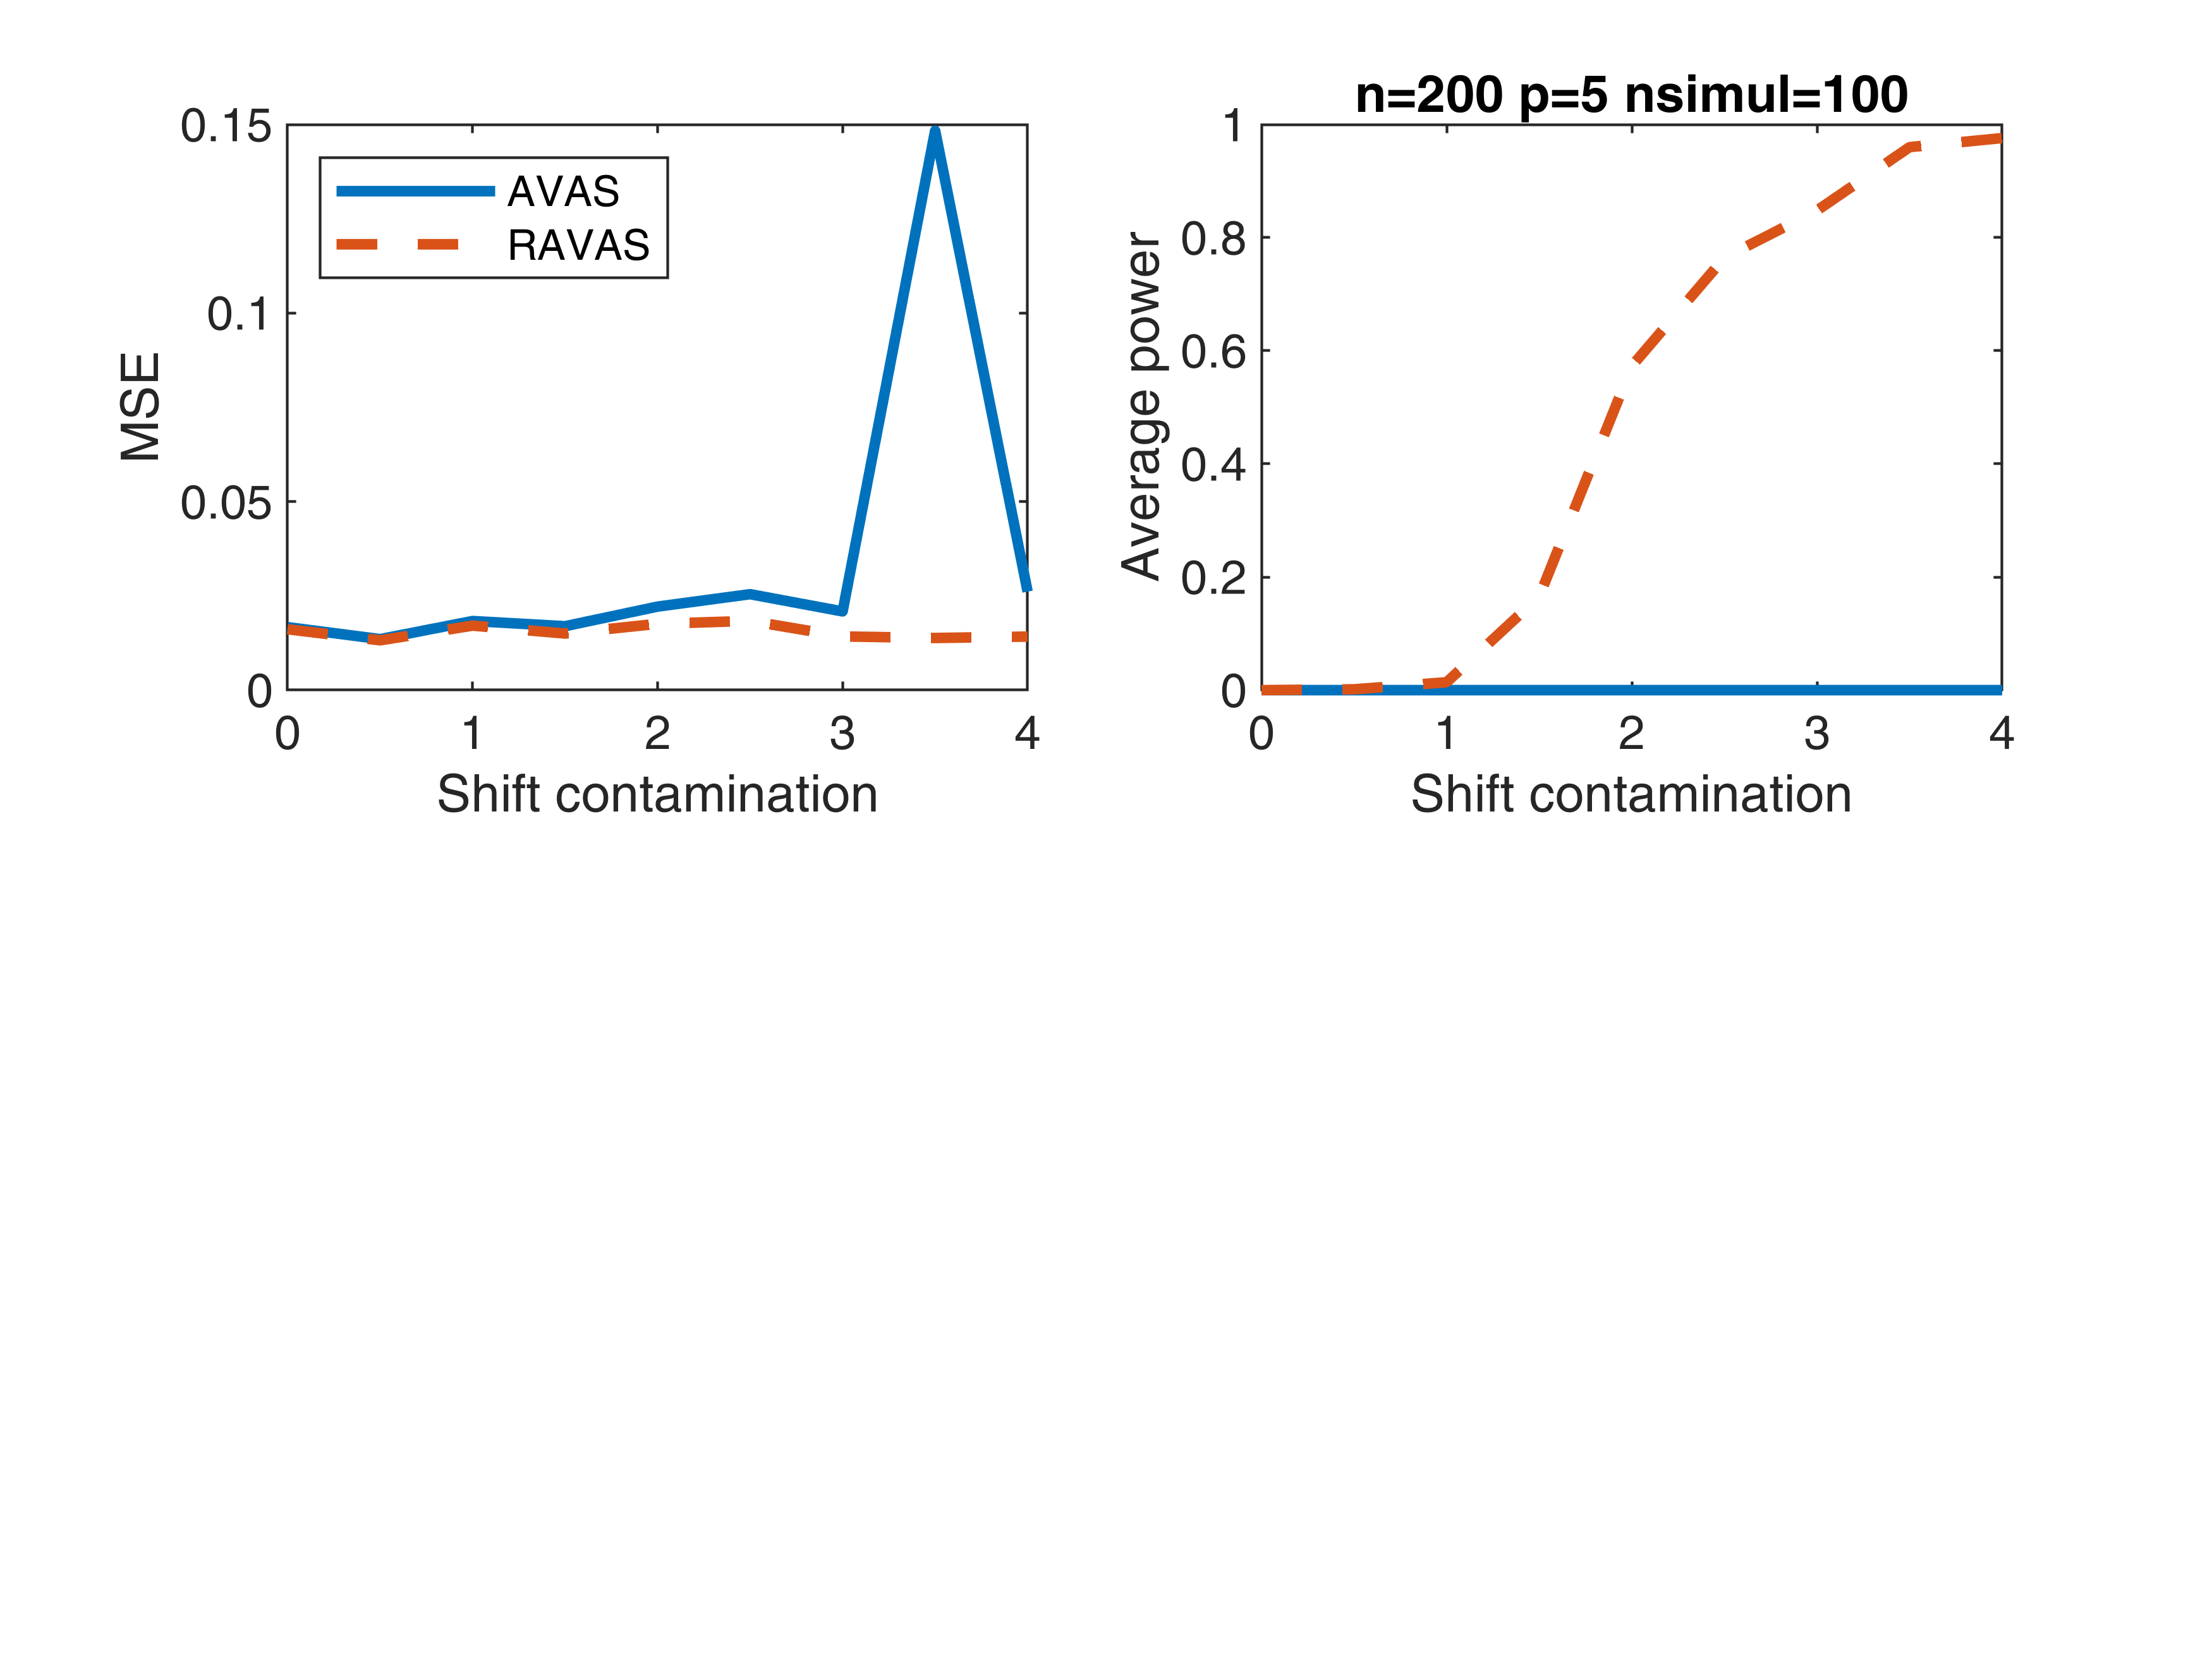

In [2]:
close all
lwd=2;

nr=2; nc=2;
subplot(nr,nc,1)
plot(LSHIFT',mseAVAS(:,1),'-',LSHIFT',mseAVAS(:,2),'--','LineWidth',lwd)
xlabel('Shift contamination')
ylabel('MSE')
% ylim([0 5])
legend({'AVAS' 'RAVAS'},'Location','northwest')

subplot(nr,nc,2)
% Percentages of true outliers found (average power)
% close all
plot(LSHIFT',zeros(9,1),'-',LSHIFT',OutliersAVASnew(:,2),'--','LineWidth',lwd)
xlabel('Shift contamination')
ylabel('Average power')
ylim([0 1])
title(['n=' num2str(n)  ' p=' num2str(p1+1)  ' nsimul=' num2str(nsimul)])

## Average number of iterations to convergence


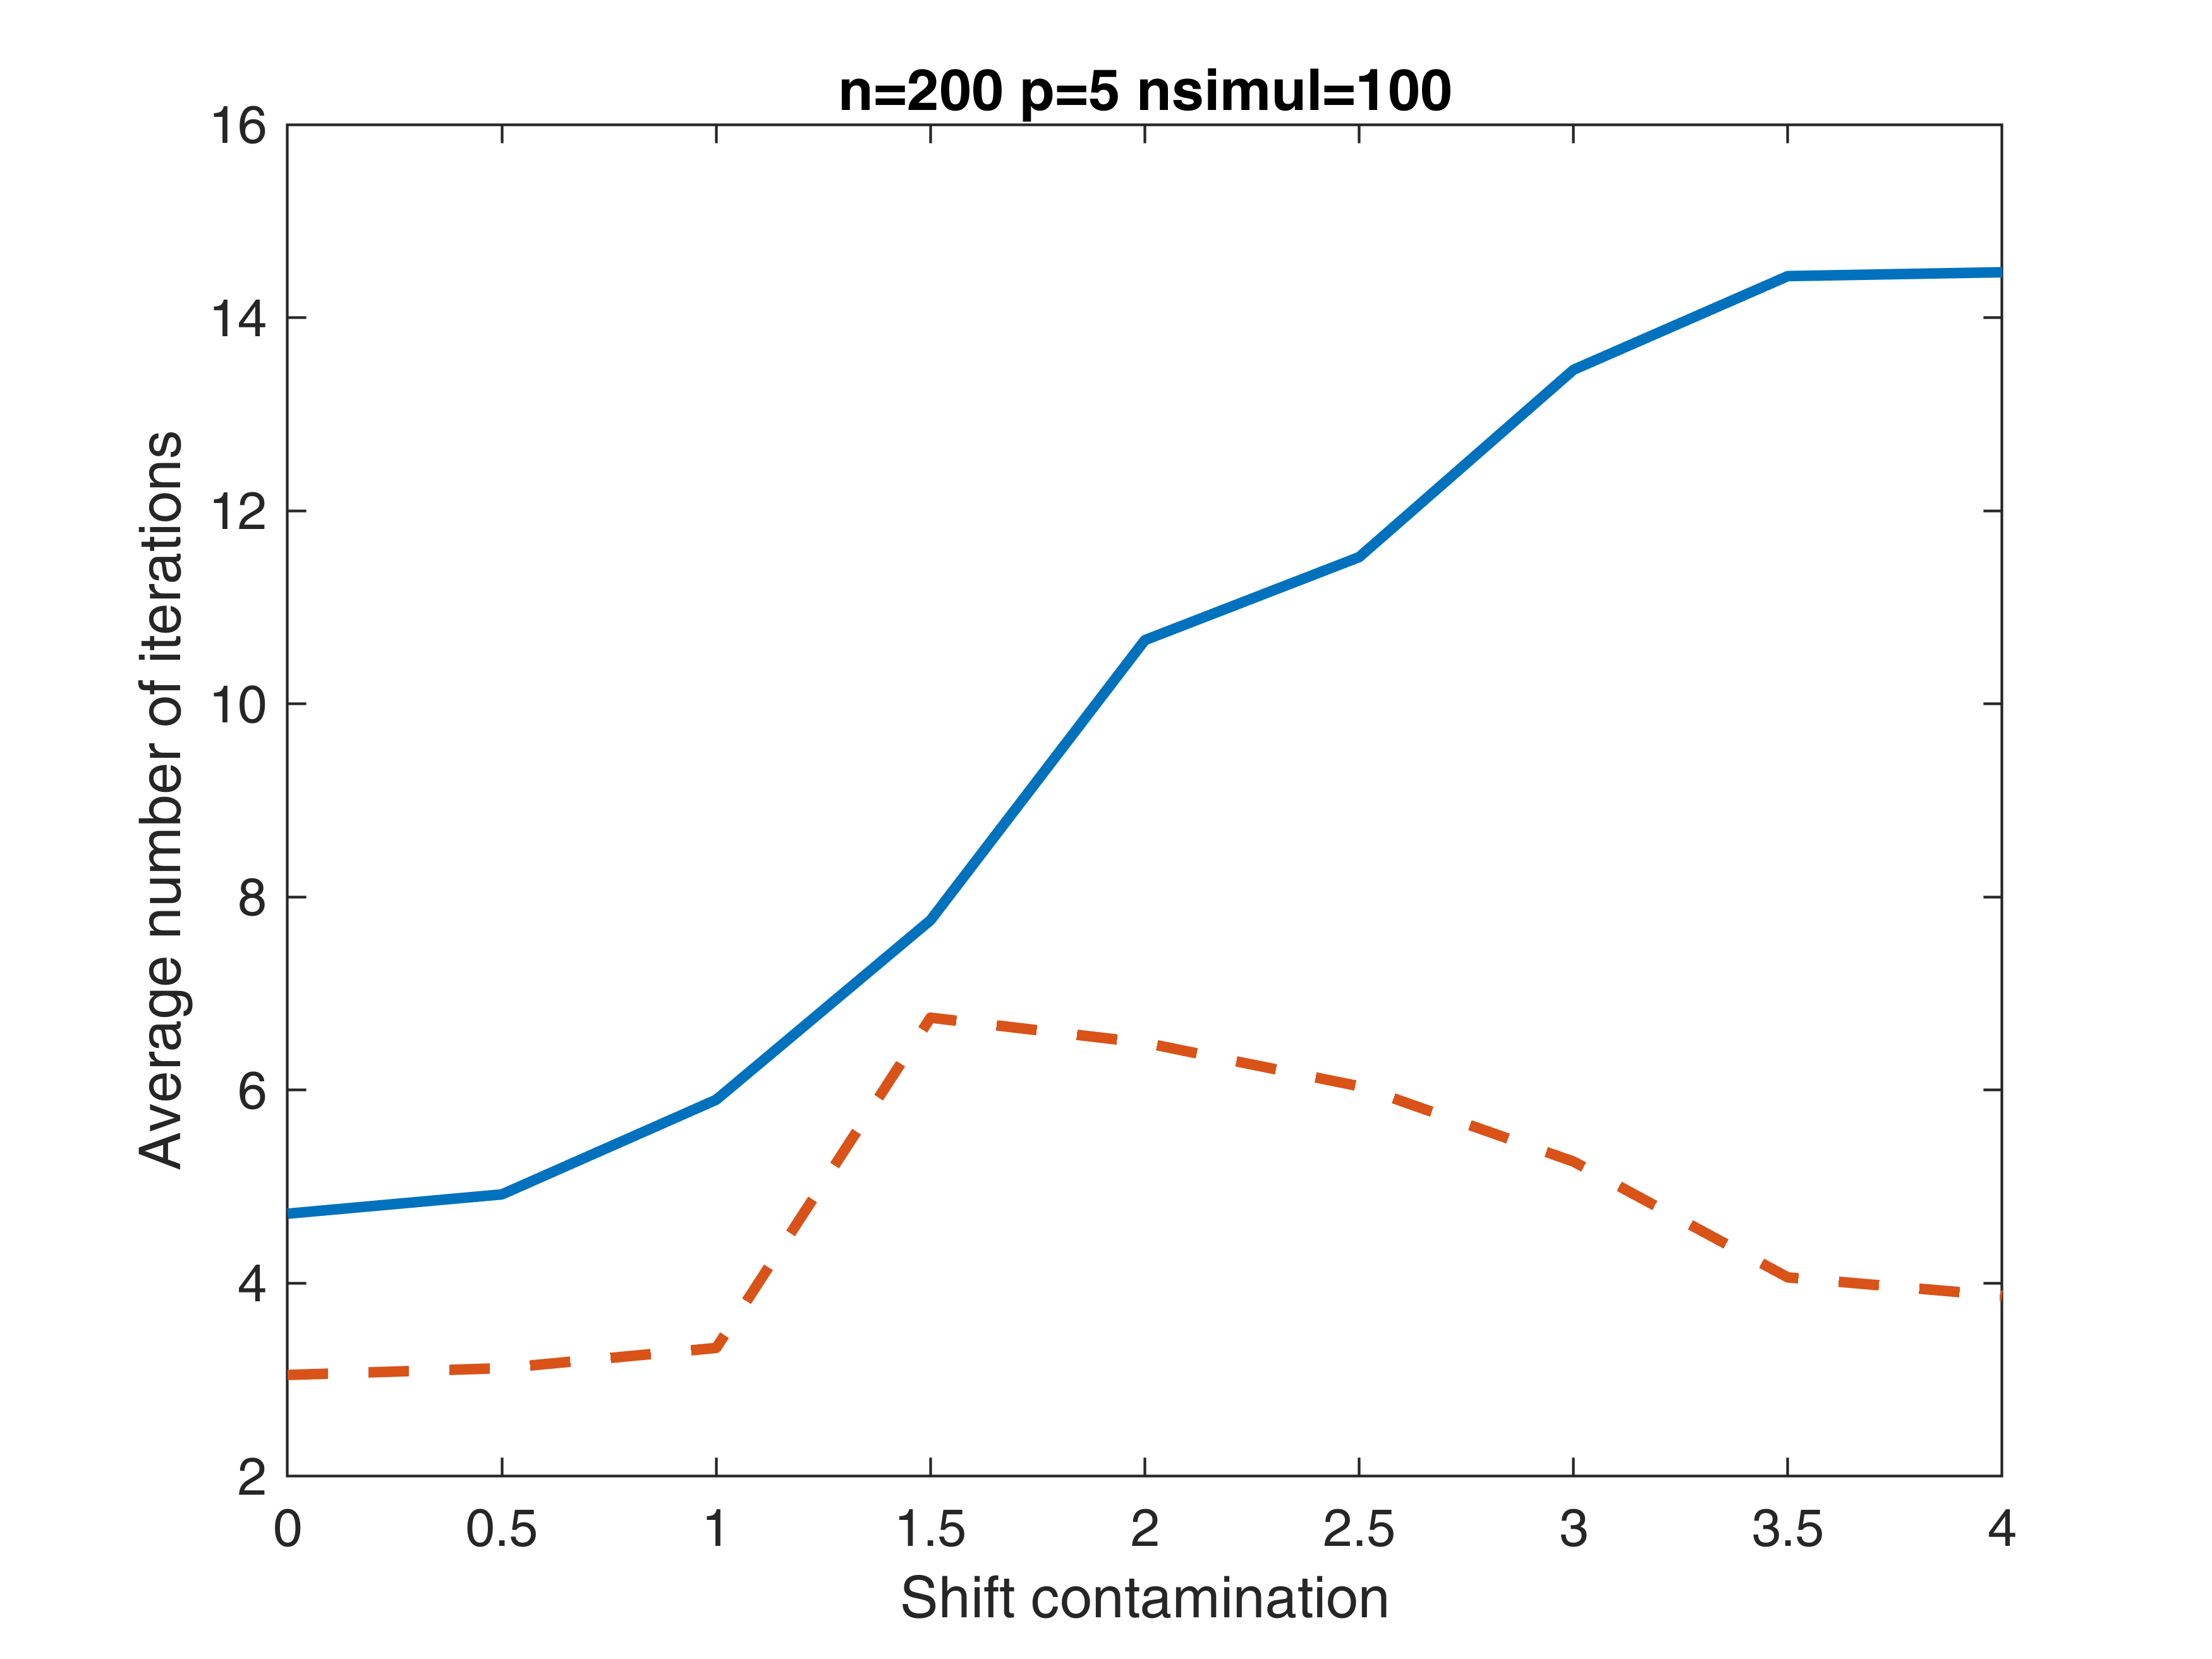

In [3]:
figure
plot(LSHIFT',Niter(:,1),'-',LSHIFT',Niter(:,2),'--','LineWidth',lwd)
xlabel('Shift contamination')
ylabel('Average number of iterations')
title(['n=' num2str(n)  ' p=' num2str(p1+1)  ' nsimul=' num2str(nsimul)])

In [4]:

if prin==1
    % print to postscript
    print -depsc figs\avNUMit.eps;

end

Unrecognized function or variable 'prin'.

In [5]:

%InsideREADME